In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import librosa
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import h5py
from pathlib import Path
from torch.utils import data
import logging
from datetime import datetime
from collections import Counter
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
import pandas as pd

In [2]:
# Wrapping the dataset with load function
class CustomDataset(data.Dataset):
    def __init__(self, file_path, transform=None):
        super().__init__()
        self.train_data_cache = []
        self.test_data_cache = []
        self.manual_data_cache = []
        self.full_test_data_cache = []
        self.transform = transform
        self.label_count = [0, 0, 0]
        # Search for all h5 files
        p = Path(file_path)
        files = p.glob('normalized*512.h5')
        logging.debug(files)
        for h5dataset_fp in files:
            logging.debug(h5dataset_fp)
            with h5py.File(h5dataset_fp.resolve()) as h5_file:
                # Walk through all groups, extracting datasets
                for gname, group in h5_file.items():
                    k = 0
                    j = 0
                    l = 0
                    if gname == 'referenz':
                        label = 0
                    elif gname == 'spitze':
                        label = 1
                    elif gname == 'grenzflaeche':
                        label = 2

                    logging.debug(group.items())
                    for dname, ds in tqdm(group.items()):
                        if k < 3000:
                            for i in np.split(ds, 2):
                                self.train_data_cache.append([label, torch.tensor(i).unsqueeze(0).type(torch.float32)])
                            k += 1
                        elif j < 400:
                            self.full_test_data_cache.append([label, ds])
                            for i in np.split(ds, 2):
                                self.test_data_cache.append([label, torch.tensor(i).unsqueeze(0).type(torch.float32)])
                            j += 1
                        elif l < 100:
                            for i in np.split(ds, 2):
                                self.manual_data_cache.append([label, torch.tensor(i).unsqueeze(0).type(torch.float32)])
                            l += 1
                        if k == 3000 and j == 400 and l == 100:
                            break
                                
    def __getitem__(self, index):
        return self.data_cache[index]

    def get_test_data(self):
        return self.test_data_cache

    def get_train_data(self):
        return self.train_data_cache

    def __len__(self):
        return len(self.data_cache)

In [3]:
# Defining the network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv1d(1, 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(2, 4, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(4, 8, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(8, 16, kernel_size=3, padding=1)  # endsize 1536 maxpool 3
        # self.conv5 = nn.Conv1d(128, 256, kernel_size=3, padding=1) #endsize 1024 maxpool 3
        # self.conv6 = nn.Conv1d(256, 512, kernel_size=3, padding=1) # endsize 512 maxpool 3

        self.fc1 = nn.Linear(48, 3) #input 1000 / 4 384//8

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 3)
        x = F.max_pool1d(F.relu(self.conv2(x)), 3)
        x = F.max_pool1d(F.relu(self.conv3(x)), 3)
        x = F.max_pool1d(F.relu(self.conv4(x)), 3)
        # x = F.max_pool1d(F.relu(self.conv5(x)),3)
        # x = F.max_pool1d(F.relu(self.conv6(x)),3)
        #logging.debug(x.shape)
        x = torch.flatten(x, 1)
        #logging.debug(x.shape)
        x = F.softmax(self.fc1(x), dim=1)

        return x

In [4]:
# loading the data
customData = CustomDataset("/home/marcus/Dokumente/entladung/")

100%|██████████| 3401/3401 [00:01<00:00, 3207.18it/s]


In [5]:

# the train loop
def train(dataloader, optimizer, criterion, model):
    model.train()
    running_loss = 0.0
    j = 0
    loss_values = []
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [labels, inputs]

        inputs = data[1]
        labels = data[0]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

        # log statistics
        running_loss += loss.item()
        if i % 500 == 499:
            print(f"[{epoch}]Loss: {running_loss / 500} ")
        
    print(f"[{epoch}] Train Loss: {running_loss / (i+1)} ") 
    plt.plot(loss_values)

In [23]:
# testing the accuracy on single 1024 snippets
def split_test(dataloader,criterion, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    ACC = []
    true = []
    pred = []
    right_pred = []
    wrong_pred = []
    test_loss, correct = 0, 0
    with torch.no_grad():
        for labels, inputs in dataloader:
            labels, inputs = labels.to(device), inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            ACC.append((torch.argmax(outputs,axis=1)==labels).float().mean().item())
            pred.extend(list((torch.argmax(outputs,axis=1).cpu().numpy())))
            true.extend(list(labels.cpu().numpy()))
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            for i, output in enumerate(outputs):
                if output.argmax(0) != labels[i]:
                    wrong_pred.append([inputs[i], labels[i], output])
                elif output.argmax(0) == labels[i]:
                    right_pred.append([inputs[i], labels[i], output])
    test_loss /= num_batches
    correct /= size
    print(f" Random Teilstück Error: Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return confusion_matrix(true, pred), confusion_matrix(true, pred, normalize='true'), wrong_pred, right_pred



In [7]:
def test_complete(dataloader, optimizer, criterion, model):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    correct = 0
    ACC = []
    true = []
    pred = []
    with torch.no_grad():
        for labels, inputs in dataloader:
            labels = labels.to(device)
            outputs = np.array([])
            for sample in inputs:
                #splitted_input = torch.reshape(sample, (4, 250)).unsqueeze(0).to(device)
                splitted_input 
                splitted_output = model(splitted_input)
                answer_count = np.array([0,0,0])
                for i in splitted_output:
                    answer_count[i.argmax(0)] += 1
                #print(answer_count, answer_count.sum())
                outputs = np.append(outputs, answer_count.argmax(0))
                ACC.append((torch.argmax(outputs,axis=1)==labels).float().mean().item())
                pred.extend(list((torch.argmax(outputs,axis=1).cpu().numpy())))
                true.extend(list(labels.cpu().numpy()))
            for i in range(len(outputs)):
                if outputs[i] == labels[i]:
                    correct += 1
            #correct += (outputs == labels).type(torch.float).sum().item()
    correct /= size
    print(f"Full Sample Error: Accuracy: {(100*correct):>0.1f}%")
    return confusion_matrix(true, pred), confusion_matrix(true, pred, normalize='true')

In [8]:
# looking for cuda device and selecting it if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [9]:
# defining the model and moving it to the correct device
model = Network().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

Network(
  (conv1): Conv1d(1, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(2, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=48, out_features=3, bias=True)
)
687


In [10]:
# defining loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# defining train and test sets
train_data = customData.get_train_data()
test_data = customData.get_test_data()
full_test_data = customData.full_test_data_cache
full_test_data = DataLoader(full_test_data, batch_size=64, shuffle=True, pin_memory=False, num_workers=0)
train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, pin_memory=False, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, pin_memory=False, num_workers=0)
manual_dataloader = DataLoader(customData.manual_data_cache, batch_size=4, shuffle=False, pin_memory=False, num_workers=0)

In [12]:

cache=[]
for i, val in enumerate( train_data):
        train_data[i][0]
        cache.append(train_data[i][0])
    
print(Counter(cache).keys())
print(Counter(cache).values())

dict_keys([2, 0, 1])
dict_values([6000, 6000, 6000])


In [13]:
cache=[]
for i, val in enumerate( test_data):
        test_data[i][0]
        cache.append(test_data[i][0])
    
print(Counter(cache).keys())
print(Counter(cache).values())

dict_keys([2, 0, 1])
dict_values([800, 800, 800])


[0] Train Loss: 0.5777075592900666 
 Random Teilstück Error: Accuracy: 97.5%, Avg loss: 0.576599
[1] Train Loss: 0.578595692842779 
 Random Teilstück Error: Accuracy: 97.2%, Avg loss: 0.578861
[2] Train Loss: 0.57788816304274 
 Random Teilstück Error: Accuracy: 97.8%, Avg loss: 0.574010
[3] Train Loss: 0.5827740086636073 
 Random Teilstück Error: Accuracy: 96.6%, Avg loss: 0.586154
[4] Train Loss: 0.5813467225558321 
 Random Teilstück Error: Accuracy: 97.6%, Avg loss: 0.575391
[5] Train Loss: 0.5791797025102965 
 Random Teilstück Error: Accuracy: 97.7%, Avg loss: 0.574587
[6] Train Loss: 0.5786676289330066 
 Random Teilstück Error: Accuracy: 97.8%, Avg loss: 0.574823
[7] Train Loss: 0.578981897360842 
 Random Teilstück Error: Accuracy: 97.8%, Avg loss: 0.574144
[8] Train Loss: 0.578860020133811 
 Random Teilstück Error: Accuracy: 97.7%, Avg loss: 0.574288
[9] Train Loss: 0.5783579651738556 
 Random Teilstück Error: Accuracy: 97.0%, Avg loss: 0.580399
[10] Train Loss: 0.5782778791978326

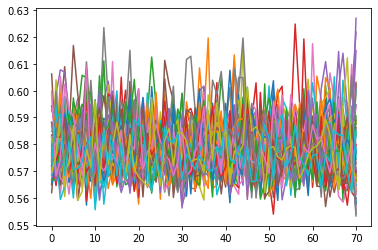

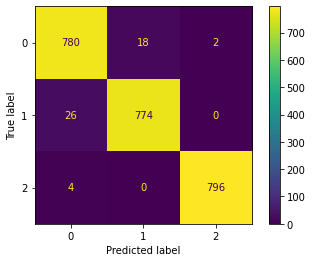

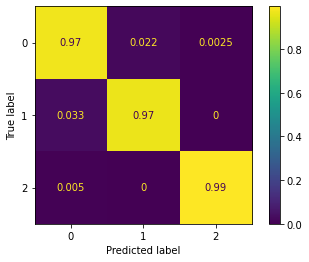

In [24]:
# training loop
for epoch in range(50):  # loop over the dataset multiple times
    loss_values=train(train_dataloader, optimizer, criterion, model)
    CM=split_test(test_dataloader, criterion, model)
    #CM2=test_complete(test_dataloader, optimizer, criterion, model)
print('Finished Training')
#print(CM[0])

disp = ConfusionMatrixDisplay(confusion_matrix=CM[0],display_labels=[0, 1, 2])
disp.plot()
plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=CM[1],display_labels=[0, 1, 2])
disp.plot()
plt.show()







tensor([4.5351e-01, 5.4648e-01, 9.9762e-06], device='cuda:0')
tensor([9.1047e-01, 8.9533e-02, 5.4899e-07], device='cuda:0')
tensor([9.4896e-01, 5.1035e-02, 5.1984e-06], device='cuda:0')
tensor([2.5606e-01, 7.4389e-01, 4.4724e-05], device='cuda:0')


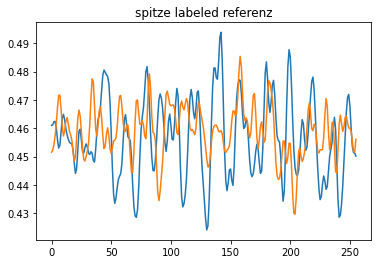

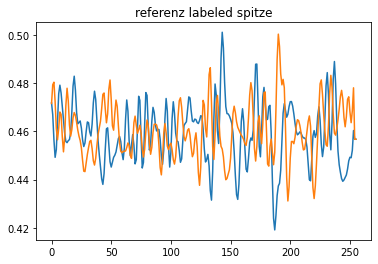

In [15]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(title="spitze labeled referenz")
fig2 = plt.figure()
ax2 = fig2.add_subplot(title="referenz labeled spitze")
j = 0
k = 0
for i in CM[2]:
    if i[1].item() == 1 and i[2].argmax(0).item() == 0 and k < 2:
        ax1.plot(range(len(i[0][0])), i[0][0].cpu())
        k += 1
        print(i[2])
    elif i[1].item() == 0 and i[2].argmax(0).item() == 1 and j < 2:
        ax2.plot(range(len(i[0][0])), i[0][0].cpu())
        j += 1
        print(i[2])
plt.show()

tensor([3.1803e-09, 1.0000e+00, 2.7012e-06], device='cuda:0')
tensor([1.3145e-30, 1.0000e+00, 9.8811e-16], device='cuda:0')
tensor([9.7766e-01, 2.2335e-02, 7.5803e-06], device='cuda:0')
tensor([9.9998e-01, 2.0163e-05, 2.3292e-07], device='cuda:0')


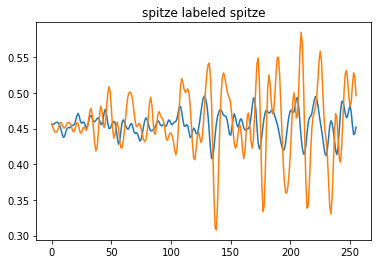

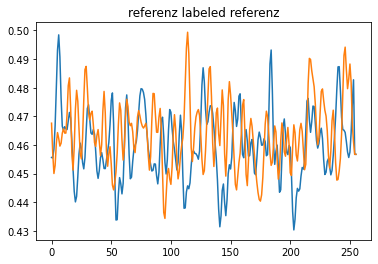

In [16]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(title="spitze labeled spitze")
fig2 = plt.figure()
ax2 = fig2.add_subplot(title="referenz labeled referenz")
j = 0
k = 0
for i in CM[3]:
    if i[1].item() == 1 and i[2].argmax(0).item() == 1 and k < 2:
        ax1.plot(range(len(i[0][0])), i[0][0].cpu())
        k += 1
        print(i[2])
    elif i[1].item() == 0 and i[2].argmax(0).item() == 0 and j < 2:
        ax2.plot(range(len(i[0][0])), i[0][0].cpu())
        j += 1
        print(i[2])
plt.show()

In [17]:
model.eval()
for labels, inputs in manual_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    logging.debug(model(inputs), labels)


In [20]:
seed = np.random.get_state()
print(seed[1])
df = pd.DataFrame(data = seed[1])
df.to_csv("entladung_randomseed3.csv")

[2147483648 1932350852 2889970672 2760237330 1272020491 1689324664
  281939903 1443628347 3055267153 2622535801 3538584859 4108712690
 1357719447 2919406283 1539942264 1873505308 4099264191 3874677467
  127457577 1884534468 4102602642 2304395027 3052823687 3738529506
 4122159417 1145447919 1084004205 1128292439 1917249276  341872169
 1809527914 4061277861 1924753043 2854873984 3461185276 1696370315
 3946412387 4234833827 1105515925 1070707430  271703547  196277403
 1854280823 2653759034 2399616765 1903767216  981797684 3202414423
 2716712071  122345571 3155373986 2306472430  701177425 1637931241
 3621811089 3591191610 2537997900 1428269448 1662717930 1734421110
  543646045 2008609521  520015439 3029447206 1672738073 3825612975
 2515400284 3443988688 3299235964 2756549252 2200773724 2056211896
 2684059057 1714895902 2604241096 3730648138  608307768 2075816307
 3276589053  296485403 3938978594 3726500916 1011473144  723083662
  848056470 2809955125 1649589027 2922286617 3429740519 425799

In [25]:
torch.save(model.state_dict(), "/home/marcus/Dokumente/entladung/best_model")